In [1]:
import pickle
import io
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

CMAP = plt.get_cmap("tab10")

def copy_fig(fig):# -> Any:
    buf = io.BytesIO()
    pickle.dump(fig, buf)
    buf.seek(0)
    return pickle.load(buf)


In [2]:
def f(x):
    return 2 * x * np.sin(x) 

def additive_noise(key, x, sigma):

    key, subkey = jax.random.split(key)

    epsilon = sigma * jax.random.normal(
        key=subkey,
        shape=(x.shape[0], ),
    )

    return key, epsilon

def noisy_f(key, x, sigma):
    key, epsilon = additive_noise(key, x, sigma=sigma)
    y = f(x) + epsilon

    return key, y


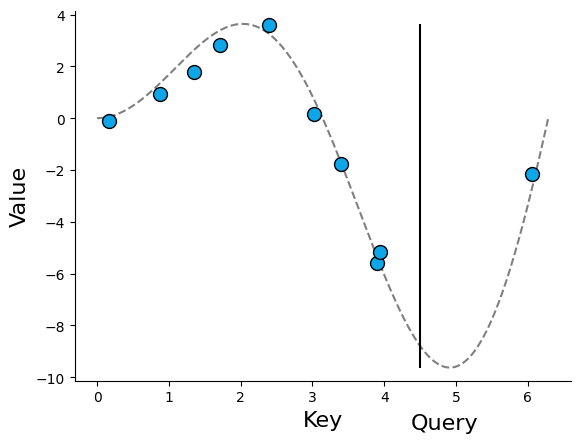

In [3]:
# Constants ====================================================================
seed = 3
N_train = 10
sigma=0.5

key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)


# Ground truth ================================================================
x_gt = jnp.arange(start=0, stop=2 * jnp.pi, step=0.01)
y_gt = f(x_gt)

# Training Data ================================================================
x_train = jax.random.uniform(key=subkey, shape=(N_train, ), minval=0, maxval=2 * jnp.pi)

key, y_train = noisy_f(key, x_train, sigma=sigma)

# The point that needs to inferred
new_point = jnp.array([4.5])

# Plotting =====================================================================
fig, ax = plt.subplots(1, 1)

ax.plot(x_gt, y_gt, '--', zorder=1, color="gray")

ax.scatter(x_train, y_train, zorder=1, color="#0ea5e9", edgecolors="black", s=100)

ylim_min = min(y_gt.min(), y_train.min())
ylim_max = max(y_gt.max(), y_train.max())

ax.set_ylim((ylim_min-0.5, ylim_max+0.5))

ax.set_xlabel("Key", fontsize=16)

ax.set_ylabel("Value", fontsize=16);

ax.spines[["right", "top"]].set_visible(False)

# Location of new point as vertical line
ax.vlines(x=new_point, ymin=ylim_min, ymax=ylim_max, colors=['k'])

ax.text(x=new_point[0]-0.125, y=-12, s="Query", fontsize=16)

fig.savefig(
    "../figures/kernel_regression.svg",
    pad_inches=0.0,
    bbox_inches=0,
    transparent=True,
)


In [4]:
def compute_dist(query, key):
    """
    Computes the norm of the distance vector between all elements in the query and key matrices.
    """
    # We have to add a 'dimension' dimension
    # In our case, just 1
    # N_query x D
    query = query[:, jnp.newaxis]

    # N_key x D
    key = key[:, jnp.newaxis]

    # N_query x N_key x D
    dist = query[:, jnp.newaxis] - key[jnp.newaxis, :]

    # N_query x N_key x 1
    dist = jnp.linalg.norm(dist, axis=-1)

    return dist

def log_gaussian_kernel(query, key, sigma: float = 1):
    """
    Computes the Gaussian kernel similarity measure
    """

    dist = compute_dist(query, key)

    # N_query x N_key
    similarity = - 0.5 * jnp.power(dist / sigma, 2)

    return similarity

def attention(query, key, kernel):

    similarity = kernel(query, key)

    attention_weights = jax.nn.softmax(similarity)

    return attention_weights


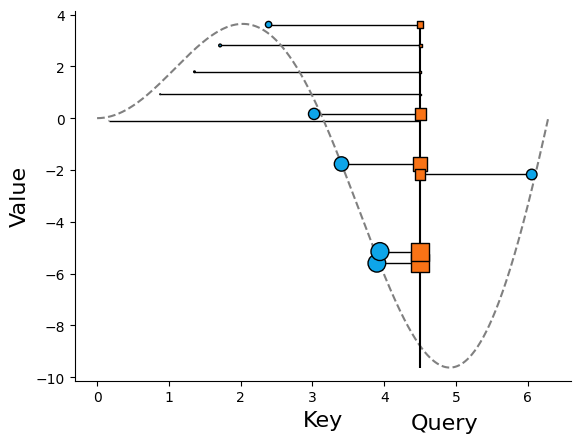

In [5]:
kernel = partial(log_gaussian_kernel, sigma=0.5)

attention_weights = attention(new_point, x_train, kernel)

# Plotting =====================================================================
fig, ax = plt.subplots(1, 1)

ax.plot(x_gt, y_gt, '--', zorder=1, color="gray")

ylim_min = min(y_gt.min(), y_train.min())
ylim_max = max(y_gt.max(), y_train.max())

ax.set_ylim((ylim_min-0.5, ylim_max+0.5))

ax.set_xlabel("Key", fontsize=16)

ax.set_ylabel("Value", fontsize=16);

ax.spines[["right", "top"]].set_visible(False)

# Rescale so things lie closer to 1
# Visually retains the idea, but colours don't fade away too quickly
attention_weights_ = jnp.power(attention_weights, 1/4)

# Location of new point as vertical line
ax.vlines(x=new_point, ymin=ylim_min, ymax=ylim_max, colors=['k'])

ax.text(x=new_point[0]-0.125, y=-12, s="Query", fontsize=16)

# Contribution of training data as lines and projected circles of varying width
for i, train_point in enumerate(zip(x_train, y_train)):

    train_point = np.array(train_point)

    ax.hlines(
        y=train_point[1],
        xmin=min(train_point[0], new_point),
        xmax=max(train_point[0], new_point),
        zorder=0,
        linewidth=1,
        colors=["black"]
        )

ax.scatter(
    x_train,
    y_train,
    zorder=1,
    color="#0ea5e9",
    edgecolors="black",
    s=200 * attention_weights_,
    )


ax.scatter(
    x=jnp.tile(new_point, reps=N_train),
    y=y_train,
    s=200 * attention_weights_,
    zorder=2,
    color="#f97316",
    edgecolors="black",
    alpha=1,
    marker="s",
    )

fig.savefig(
    "../figures/kernel_regression_weights.svg",
    pad_inches=0.0,
    bbox_inches=0,
    transparent=True,
)


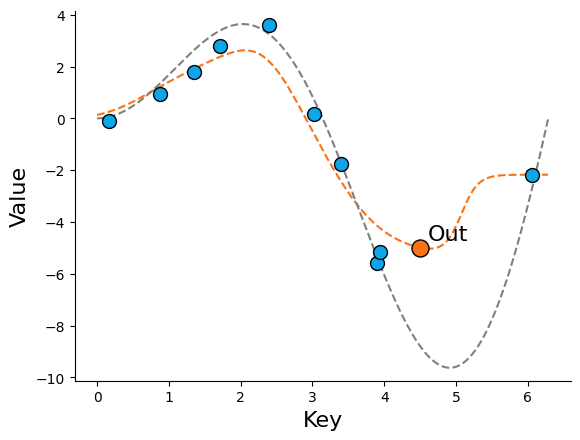

In [6]:
# Plotting =====================================================================
fig, ax = plt.subplots(1, 1)

ax.plot(x_gt, y_gt, '--', zorder=1, color="gray")

ax.scatter(x_train, y_train, zorder=1, color="#0ea5e9", edgecolors="black", s=100)

ylim_min = min(y_gt.min(), y_train.min())
ylim_max = max(y_gt.max(), y_train.max())

ax.set_ylim((ylim_min-0.5, ylim_max+0.5))

ax.set_xlabel("Key", fontsize=16)

ax.set_ylabel("Value", fontsize=16);

ax.spines[["right", "top"]].set_visible(False)

# Now plot only the new point
ax.scatter(
    x=new_point,
    y=(attention_weights * y_train).sum(),
    zorder=2,
    color="#f97316",
    s=150,
    edgecolors="black",
    )

ax.text(x=new_point[0]+0.1, y=(attention_weights * y_train).sum()+0.5, s="Out", fontsize=16, va="center")

y_pred = (attention(x_gt, x_train, kernel) * y_train).sum(axis=1)
ax.plot(
    x_gt,
    y_pred,
    zorder=0,
    color="#f97316",
    ls='--'
    )

fig.savefig(
    "../figures/kernel_regression_prediction.svg",
    pad_inches=0.0,
    bbox_inches=0,
    transparent=True,
)


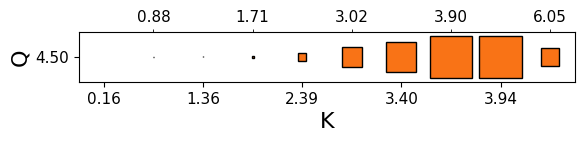

In [17]:
import matplotlib.patches
import matplotlib.ticker

fig, ax = plt.subplots(1, 1)

sort_idx = np.argsort(x_train)
adj_x_labels = x_train[sort_idx]
adj_attention_weights = attention_weights[0, sort_idx]

ax.set_aspect(10 * 1/adj_attention_weights.shape[0])

x = np.arange(0, adj_attention_weights.shape[0])
for i, a in enumerate(adj_attention_weights):
    a_ = a ** (1/5)

    ax.add_patch(
        matplotlib.patches.Rectangle(
            xy=(x[i] - a_/2, 0.5 - a_/2),
            width=a_,
            height=a_,
            facecolor="#f97316",
            edgecolor="black",
        )
    )

# ax.scatter(
#     x=np.arange(0, attention_weights.shape[1]),
#     y=np.zeros_like(attention_weights) + 0.5,
#     s=500 * attention_weights,
#     marker="s"
#     )

ax.set_yticks([])

ax.set_xticks(np.arange(0, adj_x_labels.shape[0], 2))
ax.set_xticks(np.arange(1, adj_x_labels.shape[0], 2), minor=True)

ax.set_xticklabels(list(map(lambda x: f"{x:.2f}", adj_x_labels[0::2])), fontsize=11)
ax.set_xticklabels(list(map(lambda x: f"{x:.2f}", adj_x_labels[1::2])), minor=True, fontsize=11)

ax.set_yticks(ticks=[0.5])
ax.set_yticklabels(labels=[f"{float(new_point[0]):.2f}"], fontsize=11)

ax.tick_params(
    axis="x",
    which="minor",
    direction="out",
    top=True,
    labeltop=True,
    bottom=False,
    labelbottom=False
)

ax.set_ylim(0, 1)
ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Q", fontsize=16)
ax.set_xlabel("K", fontsize=16)

fig.savefig(
    "../figures/kernel_regression_weights_matrix.svg",
    pad_inches=0.0,
    bbox_inches=0,
    transparent=True,
)


# Different Kernels

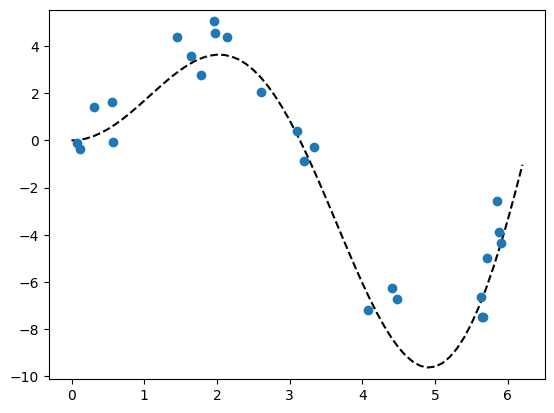

In [8]:
# Constants ====================================================================
seed = 942
N_train = 25
sigma=1.0

key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)

# Ground truth ================================================================
x_gt = jnp.arange(start=0, stop=2 * jnp.pi, step=0.1)
y_gt = f(x_gt)

# Training Data ================================================================
x_train = jax.random.uniform(key=subkey, shape=(N_train, ), minval=0, maxval=2 * jnp.pi)

key, y_train = noisy_f(key, x_train, sigma=sigma)

# Plotting =====================================================================
fig, ax = plt.subplots()
ax.plot(x_gt, y_gt, '--', zorder=1, color="black")
ax.scatter(x_train, y_train, zorder=1, color=CMAP(0))
ylim_min = min(y_gt.min(), y_train.min())
ylim_max = max(y_gt.max(), y_train.max())
ax.set_ylim((ylim_min-0.5, ylim_max+0.5));


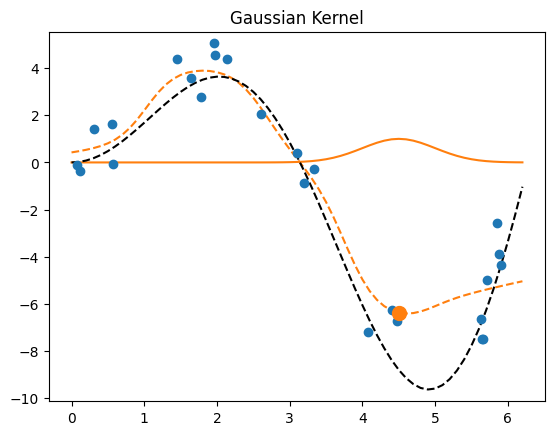

In [9]:
# Plotting =====================================================================
fig4 = copy_fig(fig)
ax4 = fig4.axes[0]

kernel = partial(log_gaussian_kernel, sigma=0.50)

attention_weights = attention(new_point, x_train, kernel=kernel)

# Now plot only the new point
ax4.scatter(
    x=new_point,
    y=(attention_weights * y_train).sum(),
    zorder=2,
    color=CMAP(1),
    s=100,
    )

y_pred = (attention(x_gt, x_train, kernel) * y_train).sum(axis=1)
ax4.plot(
    x_gt,
    y_pred,
    zorder=0,
    color=CMAP(1),
    ls='--'
    )

# Plot the kernel function
kernel_at_new_point = jnp.exp(kernel(new_point, x_gt)).flatten()
kernel_at_new_point = kernel_at_new_point / kernel_at_new_point.max()

ax4.plot(
    x_gt,
    kernel_at_new_point,
    color=CMAP(1),
    zorder=0,
)

ax4.set_title("Gaussian Kernel")

fig4


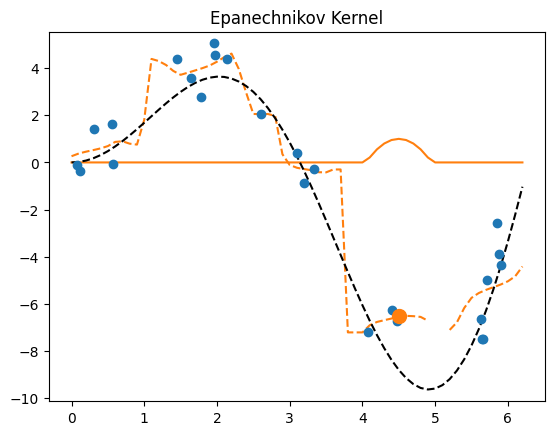

In [10]:
def log_epanechnikov_kernel(query, key, delta: float = 1):
    """
    Computes the Epanechnikov kernel similarity measure
    """

    dist = compute_dist(query, key)
    dist = dist / dist.max(axis=1)[:, jnp.newaxis]

    # N_query x N_key
    similarity = jnp.clip(0.75 * (delta * 1 - jnp.power(dist, 2)), a_min=0)

    return jnp.log(similarity)

# Plotting =====================================================================
fig4 = copy_fig(fig)
ax4 = fig4.axes[0]

kernel = partial(log_epanechnikov_kernel, delta=0.01)

attention_weights = attention(new_point, x_train, kernel=kernel)

# Now plot only the new point
ax4.scatter(
    x=new_point,
    y=(attention_weights * y_train).sum(),
    zorder=2,
    color=CMAP(1),
    s=100,
    )

y_pred = (attention(x_gt, x_train, kernel) * y_train).sum(axis=1)
ax4.plot(
    x_gt,
    y_pred,
    zorder=0,
    color=CMAP(1),
    ls='--'
    )

# Plot the kernel function
kernel_at_new_point = jnp.exp(kernel(new_point, x_gt)).flatten()
kernel_at_new_point = kernel_at_new_point / kernel_at_new_point.max()

ax4.plot(
    x_gt,
    kernel_at_new_point,
    color=CMAP(1),
    zorder=0,
)

ax4.set_title("Epanechnikov Kernel")

fig4


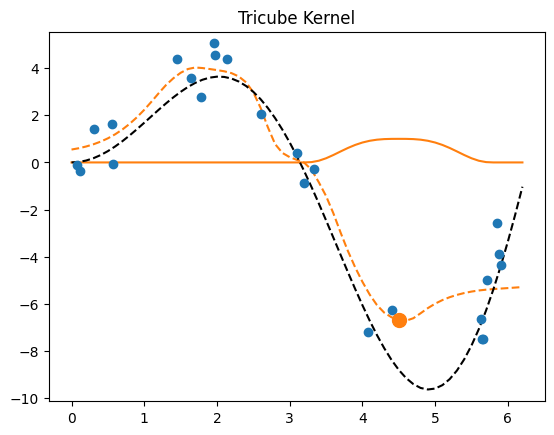

In [11]:
def log_tricube_kernel(query, key, delta: float = 1):
    """
    Computes the Gaussian kernel similarity measure
    """

    dist = compute_dist(query, key)
    dist = dist / dist.max(axis=1)[:, jnp.newaxis]

    # N_query x N_key
    similarity = jnp.clip((70 / 81) * jnp.power((delta * 1 - jnp.power(dist, 3)), 3), a_min=0)

    return jnp.log(similarity)

# Plotting =====================================================================
fig4 = copy_fig(fig)
ax4 = fig4.axes[0]

kernel = partial(log_tricube_kernel, delta=0.025)

attention_weights = attention(new_point, x_train, kernel=kernel)

# Now plot only the new point
ax4.scatter(
    x=new_point,
    y=(attention_weights * y_train).sum(),
    zorder=2,
    color=CMAP(1),
    s=100,
    )

y_pred = (attention(x_gt, x_train, kernel) * y_train).sum(axis=1)
ax4.plot(
    x_gt,
    y_pred,
    zorder=0,
    color=CMAP(1),
    ls='--'
    )

# Plot the kernel function
kernel_at_new_point = jnp.exp(kernel(new_point, x_gt)).flatten()
kernel_at_new_point = kernel_at_new_point / kernel_at_new_point.max()

ax4.plot(
    x_gt,
    kernel_at_new_point,
    color=CMAP(1),
    zorder=0,
)

ax4.set_title("Tricube Kernel")

fig4


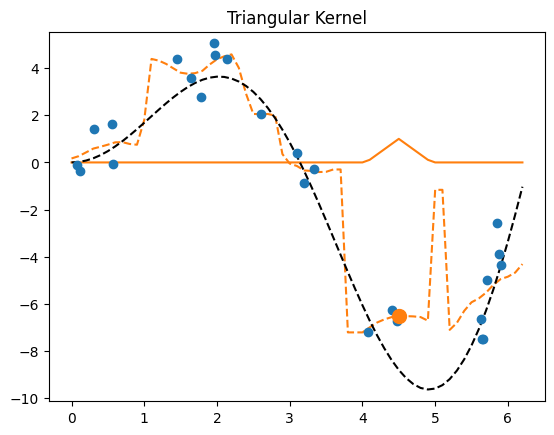

In [12]:
def log_triangular_kernel(query, key, delta: float = 1):
    """
    Computes the Gaussian kernel similarity measure
    """

    dist = compute_dist(query, key)
    dist = dist / dist.max(axis=1)[:, jnp.newaxis]

    # N_query x N_key
    similarity = jnp.clip(delta - dist, a_min=1e-9)

    return jnp.log(similarity)

# Plotting =====================================================================
fig4 = copy_fig(fig)
ax4 = fig4.axes[0]

kernel = partial(log_triangular_kernel, delta=0.1)

attention_weights = attention(new_point, x_train, kernel=kernel)

# Now plot only the new point
ax4.scatter(
    x=new_point,
    y=(attention_weights * y_train).sum(),
    zorder=2,
    color=CMAP(1),
    s=100,
    )

y_pred = (attention(x_gt, x_train, kernel) * y_train).sum(axis=1)
ax4.plot(
    x_gt,
    y_pred,
    zorder=0,
    color=CMAP(1),
    ls='--'
    )

# Plot the kernel function
kernel_at_new_point = jnp.exp(kernel(new_point, x_gt)).flatten()
kernel_at_new_point = kernel_at_new_point / kernel_at_new_point.max()

ax4.plot(
    x_gt,
    kernel_at_new_point,
    color=CMAP(1),
    zorder=0,
)

ax4.set_title("Triangular Kernel")

fig4
